## DeConveil test

In [1]:
import os
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [5]:
from pydeseq2.utils import build_design_matrix
from deconveil.dds import deconveil_fit
from deconveil.inference import Inference
from deconveil.default_inference import DefInference
from deconveil.utils_CNaware import *
from deconveil import deconveil_fit
from deconveil.ds import deconveil_stats

### Functions to run PyDESeq2 (CN-naive) & DeConveil (CN-aware)

In [7]:
def run_pydeseq2(rna_counts, metadata, output_path, design_factors="condition", alpha=0.05):
    """
    Runs PyDESeq2 analysis and saves the results.

    Parameters:
        rna_counts (pd.DataFrame): Count matrix with genes as rows and samples as columns.
        metadata (pd.DataFrame): Metadata for the samples with design factors.
        output_path (str): Directory to save the results.
        design_factors (str): Column in metadata to use for design.
        alpha (float): Significance level for statistical tests.
    """
    os.makedirs(output_path, exist_ok=True)
    
    # Initialize DESeq2 analysis
    inference = DefaultInference(n_cpus=8)
    dds = DeseqDataSet(
        counts=rna_counts,
        metadata=metadata,
        design_factors="condition",
        refit_cooks=True,
        inference=inference,
    )

    # Fit DESeq2 model
    dds.fit_size_factors()
    dds.fit_genewise_dispersions()
    dds.fit_dispersion_trend()
    dds.fit_dispersion_prior()
    dds.fit_MAP_dispersions()
    dds.fit_LFC()
    dds.calculate_cooks()
    
    if dds.refit_cooks:
        dds.refit()

    # Perform statistical analysis
    stat_res_pydeseq = DeseqStats(dds, alpha=alpha, cooks_filter=True, independent_filter=True)
    stat_res_pydeseq.run_wald_test()

    if stat_res_pydeseq.cooks_filter:
        stat_res_pydeseq._cooks_filtering()
    stat_res_pydeseq.p_values

    if stat_res_pydeseq.independent_filter:
        stat_res_pydeseq._independent_filtering()
    else:
        stat_res_pydeseq._p_value_adjustment()

    # Log-fold change shrinkage
    stat_res_pydeseq.lfc_shrink(coeff="condition_B_vs_A")
    stat_res_pydeseq.summary()

    # Save results
    results_path = os.path.join(output_path, "res_CNnaive.csv")
    stat_res_pydeseq.results_df.to_csv(results_path)
    return(stat_res_pydeseq.results_df)


def run_deconveil(rna_counts, metadata, cnv, output_path, design_factors="condition", alpha=0.05):
    """
    Runs DeConveil analysis and saves the results.

    Parameters:
        rna_counts (pd.DataFrame): Count matrix with genes as rows and samples as columns.
        metadata (pd.DataFrame): Metadata for the samples with design factors.
        cnv (pd.DataFrame): Copy number variation (CNV) data matrix  with genes as rows and samples as columns.
        output_path (str): Directory to save the results.
        design_factors (str): Column in metadata to use for design.
        alpha (float): Significance level for statistical tests.
    """
    os.makedirs(output_path, exist_ok=True)
    
    # Initialize DeConveil inference
    inference = DefInference(n_cpus=8)

    # Fit DeConveil model
    dds = deconveil_fit(
        counts=rna_counts,
        metadata=metadata,
        cnv=cnv,
        design_factors=design_factors,
        inference=inference,
        refit_cooks=True
    )
    dds.fit_size_factors()
    dds.fit_genewise_dispersions()
    dds.fit_dispersion_trend()
    dds.fit_dispersion_prior()
    dds.fit_MAP_dispersions()
    dds.fit_LFC()
    dds.calculate_cooks()

    if dds.refit_cooks:
        dds.refit()  # Replace outlier counts

    # Statistical analysis
    stat_res_deconveil = deconveil_stats(
        dds, 
        alpha=alpha, 
        independent_filter=True, 
        cooks_filter=True
    )
    stat_res_deconveil.run_wald_test()

    if stat_res_deconveil.independent_filter:
        stat_res_deconveil._independent_filtering()
    else:
        stat_res_deconveil._p_value_adjustment()

    # Log-fold change shrinkage
    stat_res_deconveil.lfc_shrink(coeff="condition_B_vs_A")
    stat_res_deconveil.summary()

    # Save results
    results_path = os.path.join(output_path, "res_CNaware.csv")
    stat_res_deconveil.results_df.to_csv(results_path)
    return(stat_res_deconveil.results_df)

### Examples of usage | Perform Inference and Statistical test

We need to perform separate DGE testing using CN-naive method, e.g *PyDESeq2* and CN-aware (*DeConveil*).
DeConveil requires the following input data: 
- matched matrixes of *mRNA read counts* (normal and tumor samples) and *CN data* (normal and tumor samples), where column names are genes and rownames are samples;
- *metadata* containing sample-specific information

Below, we provide an example using TCGA cancer data to demonstrate the application of this approach

In [78]:
# Test simulated data
#DATA_PATH = "/Users/katsiarynadavydzenka/Documents/PhD_AI/DeConveil/datasets/"
#rna_counts = pd.read_csv(os.path.join(DATA_PATH, "rna_counts.csv"), index_col=0)
#rna_counts = rna_counts.T
#metadata = pd.read_csv(os.path.join(DATA_PATH, "metadata.csv"), index_col=0)
#cnv = pd.read_csv(os.path.join(DATA_PATH, "cnv.csv"), index_col=0)
#cnv = cnv.T

Load TCGA cancer data

In [7]:
DATA_PATH = "/Users/katsiarynadavydzenka/Documents/PhD_AI/TCGA/BRCA/test"
rna_counts = pd.read_csv(os.path.join(DATA_PATH, "rna.csv"), index_col=0)
rna_counts = rna_counts.T
metadata = pd.read_csv(os.path.join(DATA_PATH, "metadata.csv"), index_col=0)
cnv = pd.read_csv(os.path.join(DATA_PATH, "cnv.csv"), index_col=0)
cnv = cnv.T
cnv = (cnv * 2).astype(int)

In [11]:
rna_counts.head()

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A2MP1,A4GALT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sample1,18,62,70194,133,35,29,1642,1910,2235,1041,...,398,266,353,898,1854,157,3238,10766,4396,2922
sample2,42,89,66754,250,52,42,310,2116,3232,188,...,1007,474,697,2229,2851,107,6250,10970,6296,8211
sample3,14,72,183713,193,60,148,1062,2122,2901,8,...,737,450,666,1777,1976,152,4618,13426,6621,5511
sample4,4,44,138900,277,160,115,1341,1939,2746,221,...,986,308,630,1880,2334,226,7503,16279,6930,5255
sample5,8,35,58746,112,54,19,1036,1556,3372,26,...,470,480,314,1001,2141,78,2772,13915,4423,2986


In [13]:
metadata.head()

,condition
sample1,A
sample2,A
sample3,A
sample4,A
sample5,A


In [15]:
cnv.head()

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A2MP1,A4GALT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sample1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
sample2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
sample3,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
sample4,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
sample5,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


Run PyDESeq2 (CN-naive) and DeConveil (CN-aware) methods

In [17]:
# PyDESeq2
pydeseq2_output_path = "/Users/katsiarynadavydzenka/Documents/PhD_AI/deconveilCaseStudies/results/BRCA/"
run_pydeseq2(rna_counts, metadata, pydeseq2_output_path)

# DeConveil
deconveil_output_path = "/Users/katsiarynadavydzenka/Documents/PhD_AI/deconveilCaseStudies/results/BRCA/"
run_deconveil(rna_counts, metadata, cnv, deconveil_output_path)    

Fitting size factors...
... done in 0.17 seconds.

Fitting dispersions...
... done in 5.71 seconds.

Fitting dispersion trend curve...
... done in 0.40 seconds.

Fitting MAP dispersions...
... done in 6.25 seconds.

Fitting LFCs...
... done in 2.99 seconds.

Calculating cook's distance...
... done in 0.57 seconds.

Replacing 2218 outlier genes.

Fitting dispersions...
... done in 0.39 seconds.

Fitting MAP dispersions...
... done in 0.54 seconds.

Fitting LFCs...
... done in 0.41 seconds.

Running Wald tests...
... done in 0.96 seconds.

Fitting MAP LFCs...
... done in 4.84 seconds.



Log2 fold change & Wald test p-value: condition B vs A
              baseMean  log2FoldChange     lfcSE       stat        pvalue  \
A1BG         12.101259        0.216933  0.127349   1.737456  8.230666e-02   
A1BG-AS1     77.956081        0.420832  0.097706   4.359761  1.302049e-05   
A2M       60702.289378       -0.265263  0.098391 -11.738713  8.070482e-32   
A2M-AS1     126.644961       -1.196387  0.109734 -11.021924  2.995857e-28   
A2ML1       371.981713        3.397818  0.293877  10.548439  5.164780e-26   
...                ...             ...       ...        ...           ...   
ZYG11A      241.321578        1.658324  0.161510  10.455134  1.388031e-25   
ZYG11B     3289.954445       -0.357462  0.060106  -3.333155  8.586712e-04   
ZYX       10157.755495       -0.425009  0.082316  -4.406815  1.049018e-05   
ZZEF1      4358.415548       -0.439077  0.065587  -6.128182  8.888876e-10   
ZZZ3       3497.912776       -0.065804  0.060881  -0.948312  3.429706e-01   

                  pa

Fitting size factors...
... done in 0.16 seconds.

Fitting dispersions...
... done in 5.64 seconds.

Fitting dispersion trend curve...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 5.99 seconds.

Fitting LFCs...
... done in 3.79 seconds.

Calculating cook's distance...
... done in 0.52 seconds.

Replacing 1970 outlier genes.



replace_mask before filtering: (220, 1970)
Number of True values in replace_mask: 3200
replacement_counts_trimmed shape: (187, 1970)


Fitting dispersions...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 0.60 seconds.

Fitting LFCs...
... done in 0.23 seconds.

Running Wald tests...
... done in 0.89 seconds.

Fitting MAP LFCs...
... done in 5.12 seconds.



Log2 fold change & Wald test p-value: condition B vs A
              baseMean  log2FoldChange     lfcSE       stat        pvalue  \
A1BG         12.101259       -0.248101  0.128128  -1.859431  6.296607e-02   
A1BG-AS1     77.956081       -0.040320  0.097715  -0.326320  7.441820e-01   
A2M       60702.289378        0.396316  0.099753 -13.259452  3.977901e-40   
A2M-AS1     126.644961       -1.582486  0.109889 -14.425079  3.598561e-47   
A2ML1       464.103817        2.806622  0.303290   9.488769  2.337791e-21   
...                ...             ...       ...        ...           ...   
ZYG11A      241.321578        1.391794  0.161342   8.857747  8.164764e-19   
ZYG11B     3232.777025       -0.603744  0.025856   2.988412  2.804312e-03   
ZYX       10157.755495       -0.680184  0.082936  -8.471871  2.414823e-17   
ZZEF1      4358.415548       -0.316560  0.065445  -5.467741  4.558067e-08   
ZZZ3       3497.912776       -0.331767  0.060655  -5.041385  4.621743e-07   

                  pa

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,12.101259,-0.248101,0.128128,-1.859431,6.296607e-02,7.863546e-02
A1BG-AS1,77.956081,-0.040320,0.097715,-0.326320,7.441820e-01,7.722366e-01
A2M,60702.289378,0.396316,0.099753,-13.259452,3.977901e-40,5.046905e-39
A2M-AS1,126.644961,-1.582486,0.109889,-14.425079,3.598561e-47,6.125044e-46
A2ML1,464.103817,2.806622,0.303290,9.488769,2.337791e-21,1.199653e-20
...,...,...,...,...,...,...
ZYG11A,241.321578,1.391794,0.161342,8.857747,8.164764e-19,3.627397e-18
ZYG11B,3232.777025,-0.603744,0.025856,2.988412,2.804312e-03,4.101768e-03
ZYX,10157.755495,-0.680184,0.082936,-8.471871,2.414823e-17,9.832096e-17
ZZEF1,4358.415548,-0.316560,0.065445,-5.467741,4.558067e-08,9.981537e-08


### Define gene groups

We are going to load previosly saved results of *PyDESeq2* and *DeConveil* methods

In [9]:
pydeseq2_output_path = "/Users/katsiarynadavydzenka/Documents/PhD_AI/deconveilCaseStudies/results/BRCA/res_CNnaive.csv"
deconveil_output_path = "/Users/katsiarynadavydzenka/Documents/PhD_AI/deconveilCaseStudies/results/BRCA/res_CNaware.csv"

Data preprocessing

We are going to define DE genes based on the following thresholds *lfc_cut = 1.0 & pval_cut = 0.05*

In [11]:
# Preprocess PyDESeq2 results
res_pydeseq = process_results(pydeseq2_output_path, "CN naive", lfc_cut = 1.0, pval_cut = 0.05)
res_pydeseq.columns = ["logFC", "padj", "isDE", "DEtype", "method"]
res_pydeseq

,logFC,padj,isDE,DEtype,method
A1BG,0.216933,1.032387e-01,False,n.s.,CN naive
A1BG-AS1,0.420832,2.449636e-05,False,n.s.,CN naive
A2M,-0.265263,7.328834e-31,False,n.s.,CN naive
A2M-AS1,-1.196387,2.282932e-27,True,Down-reg,CN naive
A2ML1,3.397818,3.475090e-25,True,Up-reg,CN naive
...,...,...,...,...,...
ZYG11A,1.658324,9.065731e-25,True,Up-reg,CN naive
ZYG11B,-0.357462,1.370348e-03,False,n.s.,CN naive
ZYX,-0.425009,1.987821e-05,False,n.s.,CN naive
ZZEF1,-0.439077,2.301828e-09,False,n.s.,CN naive


In [13]:
# Preprocess DeConveil results
res_deconveil = process_results(deconveil_output_path, "CN aware", lfc_cut = 1.0, pval_cut = 0.05)
res_deconveil.columns = ["logFC", "padj", "isDE", "DEtype", "method"]
res_deconveil

,logFC,padj,isDE,DEtype,method
A1BG,-0.248101,7.863546e-02,False,n.s.,CN aware
A1BG-AS1,-0.040320,7.722366e-01,False,n.s.,CN aware
A2M,0.396316,5.046905e-39,False,n.s.,CN aware
A2M-AS1,-1.582486,6.125044e-46,True,Down-reg,CN aware
A2ML1,2.806622,1.199653e-20,True,Up-reg,CN aware
...,...,...,...,...,...
ZYG11A,1.391794,3.627397e-18,True,Up-reg,CN aware
ZYG11B,-0.603744,4.101768e-03,False,n.s.,CN aware
ZYX,-0.680184,9.832096e-17,False,n.s.,CN aware
ZZEF1,-0.316560,9.981537e-08,False,n.s.,CN aware


Define gene groups based on the results of *CN-naive* and *CN-aware* methods: DSGs, DIGs, DCGs

In [15]:
res_joint = pd.concat([
    res_pydeseq.add_suffix("_naive"),
    res_deconveil.add_suffix("_aware")
], axis=1)
res_joint

,logFC_naive,padj_naive,isDE_naive,DEtype_naive,method_naive,logFC_aware,padj_aware,isDE_aware,DEtype_aware,method_aware
A1BG,0.216933,1.032387e-01,False,n.s.,CN naive,-0.248101,7.863546e-02,False,n.s.,CN aware
A1BG-AS1,0.420832,2.449636e-05,False,n.s.,CN naive,-0.040320,7.722366e-01,False,n.s.,CN aware
A2M,-0.265263,7.328834e-31,False,n.s.,CN naive,0.396316,5.046905e-39,False,n.s.,CN aware
A2M-AS1,-1.196387,2.282932e-27,True,Down-reg,CN naive,-1.582486,6.125044e-46,True,Down-reg,CN aware
A2ML1,3.397818,3.475090e-25,True,Up-reg,CN naive,2.806622,1.199653e-20,True,Up-reg,CN aware
...,...,...,...,...,...,...,...,...,...,...
ZYG11A,1.658324,9.065731e-25,True,Up-reg,CN naive,1.391794,3.627397e-18,True,Up-reg,CN aware
ZYG11B,-0.357462,1.370348e-03,False,n.s.,CN naive,-0.603744,4.101768e-03,False,n.s.,CN aware
ZYX,-0.425009,1.987821e-05,False,n.s.,CN naive,-0.680184,9.832096e-17,False,n.s.,CN aware
ZZEF1,-0.439077,2.301828e-09,False,n.s.,CN naive,-0.316560,9.981537e-08,False,n.s.,CN aware


In [17]:
gene_groups = define_gene_groups(res_joint)
gene_groups

{'DSGs':            logFC_naive    padj_naive  isDE_naive DEtype_naive method_naive  \
 AARD          1.976721  1.546922e-18        True       Up-reg     CN naive   
 ABAT          1.641054  6.843344e-24        True       Up-reg     CN naive   
 ABCA3         1.078939  3.786570e-18        True       Up-reg     CN naive   
 ABCB9         1.007015  3.142395e-20        True       Up-reg     CN naive   
 ABCC12        1.238684  4.221455e-04        True       Up-reg     CN naive   
 ...                ...           ...         ...          ...          ...   
 ZNF887P       1.350576  8.388363e-19        True       Up-reg     CN naive   
 ZNF92         1.038093  4.490923e-16        True       Up-reg     CN naive   
 ZNF93         1.151330  6.585788e-33        True       Up-reg     CN naive   
 ZSCAN1        1.056472  4.653589e-07        True       Up-reg     CN naive   
 ZSCAN12P1     1.171981  6.129064e-27        True       Up-reg     CN naive   
 
            logFC_aware    padj_aware  isD

In [19]:
# Extract each gene category

# Dosage-sensitive genes
d_sensitive = (
    gene_groups['DSGs']
    .rename(columns={
        'logFC_aware': 'log2FC',
        'padj_aware': 'padj',
        'isDE_aware': 'isDE',
        'DEtype_aware': 'DEtype',
        'method_aware': 'method',
        'gene_category': 'gene_group'
    })[['log2FC', 'padj', 'isDE', 'DEtype', 'method', 'gene_group']]
)

# Dosage-insensitive genes
d_insensitive = (
    gene_groups['DIGs']
    .rename(columns={
        'logFC_aware': 'log2FC',
        'padj_aware': 'padj',
        'isDE_aware': 'isDE',
        'DEtype_aware': 'DEtype',
        'method_aware': 'method',
        'gene_category': 'gene_group'
    })[['log2FC', 'padj', 'isDE', 'DEtype', 'method', 'gene_group']]
)

# Dosage-compensated genes
d_compensated = (
    gene_groups['DCGs']
    .rename(columns={
        'logFC_aware': 'log2FC',
        'padj_aware': 'padj',
        'isDE_aware': 'isDE',
        'DEtype_aware': 'DEtype',
        'method_aware': 'method',
        'gene_category': 'gene_group'
    })[['log2FC', 'padj', 'isDE', 'DEtype', 'method', 'gene_group']]
)

# non-DEGs

non_DEGs = (
    gene_groups['non_DEGs']
    .rename(columns={
        'logFC_aware': 'log2FC',
        'padj_aware': 'padj',
        'isDE_aware': 'isDE',
        'DEtype_aware': 'DEtype',
        'method_aware': 'method',
        'gene_category': 'gene_group'
    })[['log2FC', 'padj', 'isDE', 'DEtype', 'method', 'gene_group']]
)

cn_aware = pd.concat([d_sensitive, d_insensitive, d_compensated], axis=0)

In [21]:
# Dosage-sensitive genes
d_sensitive = (
    gene_groups['DSGs']
    .rename(columns={
        'logFC_naive': 'log2FC',
        'padj_naive': 'padj',
        'isDE_naive': 'isDE',
        'DEtype_naive': 'DEtype',
        'method_naive': 'method',
        'gene_category': 'gene_group'
    })[['log2FC', 'padj', 'isDE', 'DEtype', 'method', 'gene_group']]
)

# Dosage-insensitive genes
d_insensitive = (
    gene_groups['DIGs']
    .rename(columns={
        'logFC_naive': 'log2FC',
        'padj_naive': 'padj',
        'isDE_naive': 'isDE',
        'DEtype_naive': 'DEtype',
        'method_naive': 'method',
        'gene_category': 'gene_group'
    })[['log2FC', 'padj', 'isDE', 'DEtype', 'method', 'gene_group']]
)

# Dosage-compensated genes
d_compensated = (
    gene_groups['DCGs']
    .rename(columns={
        'logFC_naive': 'log2FC',
        'padj_naive': 'padj',
        'isDE_naive': 'isDE',
        'DEtype_naive': 'DEtype',
        'method_naive': 'method',
        'gene_category': 'gene_group'
    })[['log2FC', 'padj', 'isDE', 'DEtype', 'method', 'gene_group']]
)

# non-DEGs

non_DEGs = (
    gene_groups['non_DEGs']
    .rename(columns={
        'logFC_naive': 'log2FC',
        'padj_naive': 'padj',
        'isDE_naive': 'isDE',
        'DEtype_naive': 'DEtype',
        'method_naive': 'method',
        'gene_category': 'gene_group'
    })[['log2FC', 'padj', 'isDE', 'DEtype', 'method', 'gene_group']]
)

cn_naive = pd.concat([d_sensitive, d_insensitive, d_compensated], axis=0)

### Data visualization

In [23]:
# Volcano plot
plot_volcano = pd.concat([cn_naive, cn_aware], axis=0)
plot_volcano['gene_group'] = plot_volcano['gene_group'].astype("category")
plot_volcano['-log10(padj)'] = -np.log10(plot_volcano['padj'])
plot_volcano['tumor_type'] = "BRCA"
plot_volcano['method'] = pd.Categorical(plot_volcano['method'], 
                                           categories=["CN naive", "CN aware"], 
                                           ordered=True)
plot_volcano['method'] = plot_volcano['method'].map({"CN naive": "PyDESeq2", "CN aware": "DeConveil"})

lfc_cut = 1
pval_cut = 0.05

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [25]:
plot_volcano

,log2FC,padj,isDE,DEtype,method,gene_group,-log10(padj),tumor_type
AARD,1.976721,1.546922e-18,True,Up-reg,PyDESeq2,DSGs,17.810532,BRCA
ABAT,1.641054,6.843344e-24,True,Up-reg,PyDESeq2,DSGs,23.164732,BRCA
ABCA3,1.078939,3.786570e-18,True,Up-reg,PyDESeq2,DSGs,17.421754,BRCA
ABCB9,1.007015,3.142395e-20,True,Up-reg,PyDESeq2,DSGs,19.502739,BRCA
ABCC12,1.238684,4.221455e-04,True,Up-reg,PyDESeq2,DSGs,3.374538,BRCA
...,...,...,...,...,...,...,...,...
ZNF727,-1.459048,9.096181e-17,True,Down-reg,DeConveil,DCGs,16.041141,BRCA
ZNF843,-1.032809,2.056135e-33,True,Down-reg,DeConveil,DCGs,32.686948,BRCA
ZNF853,-1.097249,1.266383e-23,True,Down-reg,DeConveil,DCGs,22.897435,BRCA
ZNNT1,-1.063952,5.980050e-16,True,Down-reg,DeConveil,DCGs,15.223295,BRCA


In [27]:
cn_aware['tumor_type'] = "BRCA"
cn_aware.head()

,log2FC,padj,isDE,DEtype,method,gene_group,tumor_type
AARD,0.876650,2.435353e-05,False,n.s.,CN aware,DSGs,BRCA
ABAT,0.858547,3.727558e-08,False,n.s.,CN aware,DSGs,BRCA
ABCA3,0.255437,9.447905e-03,False,n.s.,CN aware,DSGs,BRCA
ABCB9,0.622781,8.020406e-09,False,n.s.,CN aware,DSGs,BRCA
ABCC12,0.977844,3.936172e-03,False,n.s.,CN aware,DSGs,BRCA


In [29]:
# Histogram of CN distribution
cnv = pd.read_csv(os.path.join(DATA_PATH, "cnv.csv"), index_col=0)
cnv = cnv.iloc[:, 111:220]
cnv['cnv_mean'] = cnv.mean(axis=1)
cnv_mean = cnv['cnv_mean'] * 2
cnv_mean = pd.DataFrame(cnv_mean)
cnv_mean.head()

,cnv_mean
A1BG,3.119266
A1BG-AS1,3.119266
A2M,2.981651
A2M-AS1,2.981651
A2ML1,3.000000


In [31]:
combined_data = cn_aware.merge(cnv_mean, left_index=True, right_index=True, how="left")
combined_data.head()

,log2FC,padj,isDE,DEtype,method,gene_group,tumor_type,cnv_mean
AARD,0.876650,2.435353e-05,False,n.s.,CN aware,DSGs,BRCA,5.000000
ABAT,0.858547,3.727558e-08,False,n.s.,CN aware,DSGs,BRCA,3.568807
ABCA3,0.255437,9.447905e-03,False,n.s.,CN aware,DSGs,BRCA,3.697248
ABCB9,0.622781,8.020406e-09,False,n.s.,CN aware,DSGs,BRCA,2.816514
ABCC12,0.977844,3.936172e-03,False,n.s.,CN aware,DSGs,BRCA,2.568807


In [33]:
def assign_cnv_group(cnv_mean):
    if 0.0 < cnv_mean <= 1.7:
        return "loss"
    elif 1.7 < cnv_mean <= 2.5:
        return "neutral"
    elif 2.5 < cnv_mean <= 4.0:
        return "gain"
    elif cnv_mean > 4.0:
        return "amplification"
    else:
        return None

In [35]:
# Group by 'tumor_type' and 'gene_group' and calculate counts, percentages
combined_data['cnv_group'] = combined_data['cnv_mean'].apply(assign_cnv_group)
barplot_data = combined_data.groupby(['tumor_type', 'gene_group']).size().reset_index(name='Count')
barplot_data['total'] = barplot_data.groupby('tumor_type')['Count'].transform('sum')
barplot_data['percentage'] = (barplot_data['Count'] / barplot_data['total']) * 100
barplot_data

,tumor_type,gene_group,Count,total,percentage
0,BRCA,DCGs,1307,6370,20.518053
1,BRCA,DIGs,3962,6370,62.197802
2,BRCA,DSGs,1101,6370,17.284144


In [37]:
combined_data['gene_group'] = pd.Categorical(combined_data['gene_group'], categories=["DIGs", "DSGs", "DCGs"], ordered=True)
combined_data['tumor_type'] = pd.Categorical(combined_data['tumor_type'], categories=["LUSC", "BRCA", "LIHC", "KIRC"], ordered=True)
combined_data.head()

,log2FC,padj,isDE,DEtype,method,gene_group,tumor_type,cnv_mean,cnv_group
AARD,0.876650,2.435353e-05,False,n.s.,CN aware,DSGs,BRCA,5.000000,amplification
ABAT,0.858547,3.727558e-08,False,n.s.,CN aware,DSGs,BRCA,3.568807,gain
ABCA3,0.255437,9.447905e-03,False,n.s.,CN aware,DSGs,BRCA,3.697248,gain
ABCB9,0.622781,8.020406e-09,False,n.s.,CN aware,DSGs,BRCA,2.816514,gain
ABCC12,0.977844,3.936172e-03,False,n.s.,CN aware,DSGs,BRCA,2.568807,gain


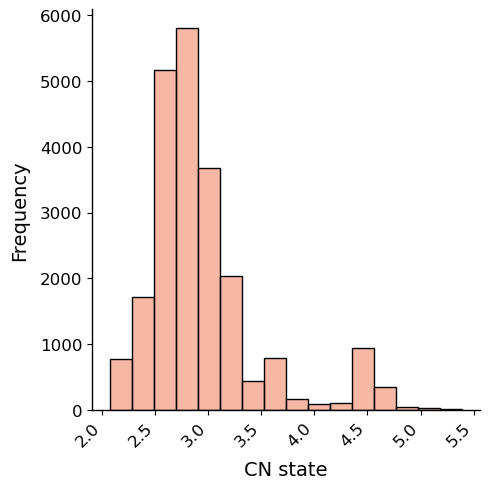

<Figure size 500x500 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


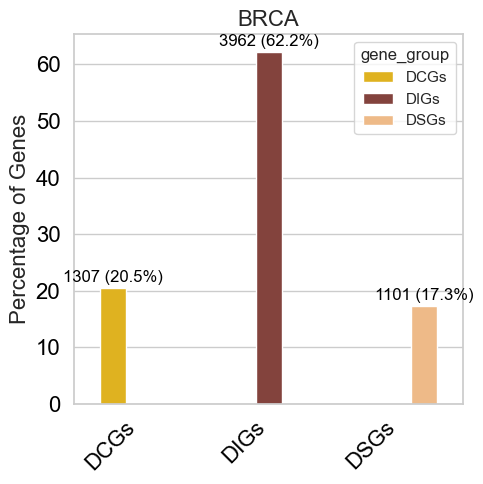

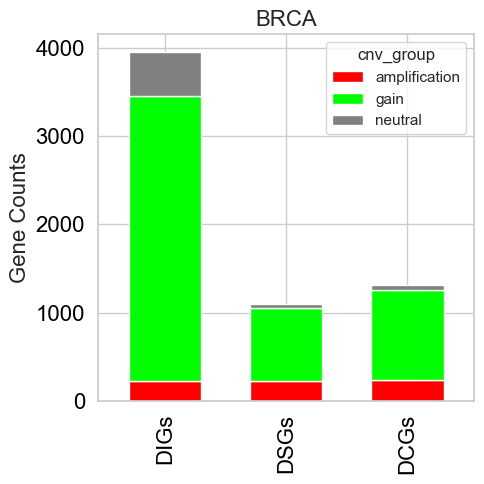

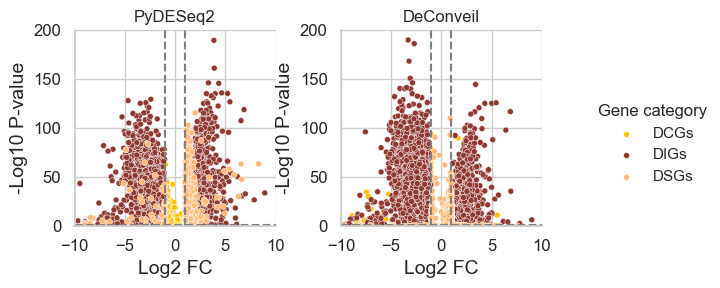

In [39]:
plot_cnv_hist(cnv_mean, binwidth=0.2)
plot_percentage_bar(barplot_data)
plot_stacked_bar(combined_data)
generate_volcano_plot(plot_volcano, xlim = (-10,10), ylim = (0, 200))